In [49]:
import torch
import sys

sys.path.append("../")

from models.resnet import resnet8
from models.alexnet import alexnet
from models.lenet import LeNet
import pandas
from data_preprocessing.cifar10.data_loader import get_client_idxes_dict, get_client_dataloader
dict_client_idexes, class_num, client_infos = get_client_idxes_dict("/mnt/data/th/FedTH/data/dataset/cifar10/", "hetero", 0.3, 20)

test_dl = get_client_dataloader("/mnt/data/th/FedTH/data/dataset/cifar10", 64, {}, client_idx=None, train=False)


INFO:root:*********partition data***************
INFO:root:N = 50000
INFO:root:traindata_cls_counts = {0: {0: 338, 1: 220, 2: 1000, 3: 25, 5: 60, 6: 190, 7: 43, 8: 4, 9: 49}, 1: {0: 7, 1: 154, 2: 6, 3: 5, 4: 58, 5: 469, 6: 195, 7: 98, 8: 18, 9: 657}, 2: {0: 275, 1: 1, 2: 243, 3: 55, 4: 90, 5: 62, 6: 968, 7: 32, 8: 81, 9: 6}, 3: {1: 112, 2: 34, 3: 15, 4: 17, 6: 1, 7: 342, 8: 43, 9: 23}, 4: {0: 351, 1: 32, 2: 3, 4: 186, 5: 25, 7: 351, 8: 5, 9: 279}, 5: {0: 862, 1: 53, 2: 31, 3: 130, 4: 8, 5: 300, 6: 930, 7: 189}, 6: {0: 52, 1: 1678, 2: 1415}, 7: {0: 769, 1: 21, 3: 161, 5: 838, 6: 5, 7: 165, 8: 743}, 8: {0: 230, 1: 182, 2: 17, 3: 3, 5: 153, 6: 2, 7: 863, 8: 88, 9: 1029}, 9: {0: 1, 2: 79, 3: 2, 4: 209, 5: 1, 6: 1825, 7: 1, 8: 16, 9: 33}, 10: {0: 12, 1: 1448, 2: 1376}, 11: {0: 686, 1: 127, 2: 8, 3: 818, 4: 138, 5: 513, 6: 1, 7: 2, 8: 10, 9: 2461}, 12: {0: 379, 1: 74, 2: 112, 3: 590, 4: 54, 6: 7, 7: 1471}, 13: {0: 190, 1: 4, 2: 528, 3: 1123, 4: 442, 5: 1109}, 14: {0: 632, 1: 142, 2: 56, 3: 9

In [50]:
from models.resnet_balance import resnet_fedbalance_experimental

In [98]:
for i in range(10):
    print("-------------------------------------"+str(i)+"--------------------------------------------")
    train_dl, val_dl = get_client_dataloader(
                "/mnt/data/th/FedTH/data/dataset/cifar10", 64, dict_client_idexes, client_idx=i, train=True)
    model = resnet_fedbalance_experimental(LeNet(10),resnet8(10))
    device = torch.device('cuda')
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    client_dis_ = client_infos[i]
    client_dis = []
    for j in range(10):
        if j in client_dis_:
            client_dis.append(client_dis_[j])
        else:
            client_dis.append(0)
    client_dis = torch.Tensor(client_dis)
    dist = client_dis / client_dis.sum()  # 个数的比例
    cdist = dist#/dist.max()
    cdist = cdist.reshape((1, -1))
    cdist.to(device)
    model.to(device)
    model.train()

    epoch_loss = []
    for epoch in range(10):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            model.zero_grad()
            probs = model(images, cdist.to(device))
            loss = criterion(probs, labels)
            loss.backward()
#             print((model.model_global.fc.weight.grad.abs().sum()/model.model_global.fc.weight.abs().sum()).item(),(model.model_local.fc_3.weight.grad.abs().sum()/model.model_local.fc_3.weight.abs().sum()).item())
            optimizer.step()
            batch_loss.append(loss.item())

    model.eval()
    res = []
    res_probs = []

    for batch_idx, (images, labels) in enumerate(train_dl):
        for img,label in zip(images,labels):
            img = img.to(device)
            logits_local = model.model_local(img.unsqueeze(0)).to('cpu')
            probs_local = torch.softmax(logits_local,-1)
            logits_global = model.model_global(img.unsqueeze(0)).to('cpu')
            probs_global = torch.softmax(logits_global,-1)
            logits_combine = logits_local*cdist+logits_global
            probs_combine = torch.softmax(logits_combine,-1)
            res.append((label.item(),logits_local[0][label].item(),logits_global[0][label].item(),logits_combine[0][label].item()))
            res_probs.append((label.item(),probs_local[0][label].item(),probs_global[0][label].item(),probs_combine[0][label].item()))
    import pandas
    df = pandas.DataFrame(res)
    df.columns = ['label','local','global','combine']
   
    df_probs = pandas.DataFrame(res_probs)
    df_probs.columns = ['label','local','global','combine']
    df_probs.groupby('label').mean()
    print(cdist)
    print( df.groupby('label').mean())
    print(df_probs.groupby('label').mean())
            # print(logits_local,logits_global)

    

-------------------------------------0--------------------------------------------


INFO:root:train batch: 30,val batch: 156


tensor([[0.1752, 0.1140, 0.5184, 0.0130, 0.0000, 0.0311, 0.0985, 0.0223, 0.0021,
         0.0254]])
          local    global   combine
label                              
0      0.009917  2.146183  2.147920
1     -0.003860  1.177953  1.177513
2      0.180318  2.696563  2.790040
3      0.109326 -0.919143 -0.917726
5     -0.096733 -0.302516 -0.305524
6     -0.071995  1.097389  1.090297
7     -0.042450 -0.623937 -0.624883
8     -0.031581 -1.381348 -1.381413
9     -0.079318 -0.425616 -0.427631
          local    global   combine
label                              
0      0.101457  0.346718  0.336254
1      0.100135  0.156013  0.149979
2      0.120429  0.550391  0.571531
3      0.112199  0.018292  0.017516
5      0.091250  0.034645  0.032966
6      0.093580  0.126324  0.119333
7      0.096356  0.024373  0.023206
8      0.097611  0.011983  0.011594
9      0.092909  0.030759  0.029518
-------------------------------------1--------------------------------------------


INFO:root:train batch: 26,val batch: 156


tensor([[0.0042, 0.0924, 0.0036, 0.0030, 0.0348, 0.2813, 0.1170, 0.0588, 0.0108,
         0.3941]])
          local    global   combine
label                              
0     -0.052313 -1.503026 -1.503246
1     -0.052016  0.893433  0.888628
2     -0.057090 -1.271005 -1.271211
3     -0.069495 -1.287795 -1.288003
4     -0.047025 -0.302727 -0.304363
5      0.114740  1.940965  1.973246
6     -0.052093  1.309585  1.303492
7     -0.062964  0.263594  0.259892
8     -0.101298 -0.813658 -0.814752
9      0.049264  2.514476  2.533892
          local    global   combine
label                              
0      0.098005  0.009389  0.009250
1      0.097955  0.098288  0.096420
2      0.097695  0.014061  0.013913
3      0.096360  0.012386  0.012229
4      0.098841  0.035549  0.035155
5      0.116150  0.326962  0.333691
6      0.098368  0.180930  0.178129
7      0.096987  0.056372  0.055430
8      0.093288  0.016427  0.016153
9      0.108290  0.490480  0.492053
------------------------------------

INFO:root:train batch: 28,val batch: 156


tensor([[0.1517, 0.0006, 0.1340, 0.0303, 0.0496, 0.0342, 0.5339, 0.0177, 0.0447,
         0.0033]])
          local    global   combine
label                              
0      0.080064  2.206105  2.218249
1      0.021228 -1.480503 -1.480491
2     -0.043429  1.132225  1.126404
3      0.056546 -0.394101 -0.392386
4     -0.055364  0.020509  0.017760
5     -0.066546 -0.326011 -0.328286
6      0.259931  2.624965  2.763748
7      0.085451 -0.822970 -0.821462
8      0.091099  0.670536  0.674606
9     -0.070562 -1.354395 -1.354629
          local    global   combine
label                              
0      0.103777  0.430818  0.427527
1      0.097590  0.009964  0.009065
2      0.091862  0.148679  0.138463
3      0.101409  0.033664  0.031593
4      0.090689  0.049563  0.045937
5      0.089549  0.038048  0.035442
6      0.124183  0.616616  0.645826
7      0.104203  0.023158  0.021538
8      0.104945  0.094675  0.092428
9      0.089047  0.014947  0.014310
------------------------------------

INFO:root:train batch: 9,val batch: 156


tensor([[0.0000, 0.1908, 0.0579, 0.0256, 0.0290, 0.0000, 0.0017, 0.5826, 0.0733,
         0.0392]])
          local    global   combine
label                              
1      0.106950  1.336824  1.357230
2      0.028839 -0.019399 -0.017729
3      0.001856 -0.428504 -0.428456
4     -0.042231 -0.447858 -0.449081
6      0.014869 -0.858820 -0.858795
7      0.204905  2.330129  2.449511
8      0.014550  0.015800  0.016866
9      0.033573 -0.143093 -0.141777
          local    global   combine
label                              
1      0.107426  0.191068  0.181914
2      0.099447  0.060881  0.057471
3      0.096721  0.037458  0.035119
4      0.092737  0.038375  0.036030
6      0.098337  0.026747  0.025236
7      0.118681  0.535525  0.562633
8      0.097885  0.058502  0.055121
9      0.099757  0.046833  0.043872
-------------------------------------4--------------------------------------------


INFO:root:train batch: 19,val batch: 156


tensor([[0.2849, 0.0260, 0.0024, 0.0000, 0.1510, 0.0203, 0.0000, 0.2849, 0.0041,
         0.2265]])
          local    global   combine
label                              
0      0.052849  2.609740  2.624796
1      0.060330 -0.400862 -0.399295
2     -0.118500 -0.987910 -0.988198
4      0.070682  1.324772  1.335443
5     -0.032929 -0.530513 -0.531182
7      0.110097  2.021429  2.052796
8     -0.074185 -1.034359 -1.034661
9     -0.029958  1.953807  1.947023
          local    global   combine
label                              
0      0.104430  0.410863  0.412026
1      0.105126  0.026522  0.026245
2      0.087900  0.018390  0.018143
4      0.106343  0.167833  0.167491
5      0.095859  0.024723  0.024393
7      0.110571  0.297711  0.303291
8      0.091894  0.015168  0.014970
9      0.096201  0.249363  0.244676
-------------------------------------5--------------------------------------------


INFO:root:train batch: 39,val batch: 156


tensor([[0.3444, 0.0212, 0.0124, 0.0519, 0.0032, 0.1199, 0.3716, 0.0755, 0.0000,
         0.0000]])
          local    global   combine
label                              
0     -0.046439  3.616415  3.600422
1      0.087368 -0.587847 -0.585997
2     -0.045742 -0.947861 -0.948428
3     -0.026278  0.420925  0.419560
4     -0.069185 -1.328652 -1.328873
5     -0.139764  1.320976  1.304224
6      0.046894  2.789061  2.806485
7      0.061511  0.869996  0.874640
          local    global   combine
label                              
0      0.097412  0.643473  0.640909
1      0.111277  0.020104  0.020167
2      0.097381  0.014345  0.014284
3      0.099336  0.057194  0.057173
4      0.095044  0.009938  0.009891
5      0.088673  0.143823  0.141406
6      0.106803  0.561653  0.567142
7      0.108432  0.083806  0.084028
-------------------------------------6--------------------------------------------


INFO:root:train batch: 49,val batch: 156


tensor([[0.0165, 0.5335, 0.4499, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])
          local    global   combine
label                              
0     -0.100848  0.379840  0.378172
1      0.224108  5.032524  5.152095
2      0.127871  4.903533  4.961064
          local    global   combine
label                              
0      0.085216  0.012919  0.011849
1      0.117331  0.746096  0.755932
2      0.106913  0.705065  0.698568
-------------------------------------7--------------------------------------------


INFO:root:train batch: 42,val batch: 156


tensor([[0.2846, 0.0078, 0.0000, 0.0596, 0.0000, 0.3101, 0.0019, 0.0611, 0.2750,
         0.0000]])
          local    global   combine
label                              
0      0.135172  2.871459  2.909929
1      0.058168 -1.207844 -1.207392
3      0.050096  0.866823  0.869808
5      0.033906  2.640892  2.651408
6     -0.077770 -1.413957 -1.414101
7      0.114074  0.946240  0.953206
8      0.100915  2.806810  2.834560
          local    global   combine
label                              
0      0.110840  0.366199  0.369892
1      0.102609  0.009728  0.009528
3      0.101758  0.077946  0.076976
5      0.100124  0.493891  0.491626
6      0.089588  0.007962  0.007856
7      0.108516  0.087654  0.086861
8      0.107063  0.367873  0.368033
-------------------------------------8--------------------------------------------


INFO:root:train batch: 40,val batch: 156


tensor([[0.0896, 0.0709, 0.0066, 0.0012, 0.0000, 0.0596, 0.0008, 0.3362, 0.0343,
         0.4009]])
          local    global   combine
label                              
0     -0.109420  1.372161  1.362357
1     -0.090403  0.902647  0.896238
2     -0.077729 -1.270545 -1.271060
3     -0.015365 -1.722044 -1.722062
5      0.016243  0.581595  0.582563
6     -0.057577 -1.548721 -1.548766
7      0.023779  2.588494  2.596488
8     -0.071440  0.042098  0.039649
9      0.023508  2.630993  2.640416
          local    global   combine
label                              
0      0.093422  0.179765  0.178068
1      0.095170  0.074075  0.073304
2      0.096548  0.009775  0.009746
3      0.102847  0.006320  0.006312
5      0.105906  0.059946  0.059814
6      0.097297  0.008922  0.008842
7      0.106648  0.416992  0.418452
8      0.097024  0.043841  0.043614
9      0.106535  0.441664  0.443562
-------------------------------------9--------------------------------------------


INFO:root:train batch: 33,val batch: 156


tensor([[4.6147e-04, 0.0000e+00, 3.6456e-02, 9.2293e-04, 9.6447e-02, 4.6147e-04,
         8.4218e-01, 4.6147e-04, 7.3835e-03, 1.5228e-02]])
          local    global   combine
label                              
0      0.040069 -1.267215 -1.267196
2      0.077380  0.639975  0.642796
3     -0.058253 -0.881349 -0.881403
4      0.119038  1.807459  1.818940
5      0.051354 -1.089436 -1.089412
6      0.175341  3.992759  4.140427
7     -0.004767 -0.776422 -0.776424
8     -0.013829 -0.534741 -0.534843
9     -0.029716 -0.166828 -0.167281
          local    global   combine
label                              
0      0.101713  0.009096  0.008200
2      0.106046  0.038178  0.034027
3      0.092576  0.008492  0.007504
4      0.110716  0.115328  0.103892
5      0.103205  0.008549  0.007459
6      0.117072  0.821198  0.840653
7      0.098050  0.009235  0.008151
8      0.096816  0.014846  0.013224
9      0.095445  0.015598  0.013793


In [97]:
for i in range(10):
    print("-------------------------------------"+str(i)+"--------------------------------------------")
    train_dl, val_dl = get_client_dataloader(
                "/mnt/data/th/FedTH/data/dataset/cifar10", 64, dict_client_idexes, client_idx=i, train=True)
    model = resnet8(10)
    device = torch.device('cuda')
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    client_dis_ = client_infos[i]
    client_dis = []
    for j in range(10):
        if j in client_dis_:
            client_dis.append(client_dis_[j])
        else:
            client_dis.append(0)
    client_dis = torch.Tensor(client_dis)
    dist = client_dis / client_dis.sum()  # 个数的比例
    cdist = dist#/dist.max()
    cdist = cdist.reshape((1, -1))
    cdist.to(device)
    model.to(device)
    model.train()

    epoch_loss = []
    for epoch in range(10):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            model.zero_grad()
            probs = model(images)
            loss = criterion(probs, labels)
            loss.backward()
#             print((model.model_global.fc.weight.grad.abs().sum()/model.model_global.fc.weight.abs().sum()).item(),(model.model_local.fc_3.weight.grad.abs().sum()/model.model_local.fc_3.weight.abs().sum()).item())
            optimizer.step()
            batch_loss.append(loss.item())

    model.eval()
    res = []
    res_probs = []

    for batch_idx, (images, labels) in enumerate(train_dl):
        for img,label in zip(images,labels):
            img = img.to(device)
            logits_global = model(img.unsqueeze(0)).to('cpu')
            probs_global = torch.softmax(logits_global,-1)
            res.append((label.item(),logits_global[0][label].item()))
            res_probs.append((label.item(),probs_global[0][label].item()))
    import pandas
    df = pandas.DataFrame(res)
    df.columns = ['label','global']
   
    df_probs = pandas.DataFrame(res_probs)
    df_probs.columns = ['label','global']
    df_probs.groupby('label').mean()
    print(cdist)
    print( df.groupby('label').mean())
    print(df_probs.groupby('label').mean())
            # print(logits_local,logits_global)

    

-------------------------------------0--------------------------------------------


INFO:root:train batch: 30,val batch: 156


tensor([[0.1752, 0.1140, 0.5184, 0.0130, 0.0000, 0.0311, 0.0985, 0.0223, 0.0021,
         0.0254]])
         global
label          
0      2.119080
1      1.269551
2      2.689396
3     -1.016010
5     -0.359350
6      1.001353
7     -0.754847
8     -1.332983
9     -0.386633
         global
label          
0      0.327253
1      0.165178
2      0.566499
3      0.016006
5      0.030780
6      0.121461
7      0.020966
8      0.010601
9      0.031052
-------------------------------------1--------------------------------------------


INFO:root:train batch: 26,val batch: 156


tensor([[0.0042, 0.0924, 0.0036, 0.0030, 0.0348, 0.2813, 0.1170, 0.0588, 0.0108,
         0.3941]])
         global
label          
0     -1.417523
1      1.070192
2     -1.234610
3     -1.292451
4     -0.283299
5      1.973407
6      1.107322
7      0.239672
8     -1.024311
9      2.686501
         global
label          
0      0.007480
1      0.100267
2      0.015230
3      0.013824
4      0.039986
5      0.342766
6      0.168757
7      0.056596
8      0.012817
9      0.509603
-------------------------------------2--------------------------------------------


INFO:root:train batch: 28,val batch: 156


tensor([[0.1517, 0.0006, 0.1340, 0.0303, 0.0496, 0.0342, 0.5339, 0.0177, 0.0447,
         0.0033]])
         global
label          
0      2.160555
1     -1.281236
2      1.232851
3     -0.404723
4      0.117841
5     -0.310204
6      2.935765
7     -0.744880
8      0.568186
9     -1.388818
         global
label          
0      0.407884
1      0.010923
2      0.138058
3      0.028938
4      0.044729
5      0.033471
6      0.652928
7      0.020511
8      0.083879
9      0.013160
-------------------------------------3--------------------------------------------


INFO:root:train batch: 9,val batch: 156


tensor([[0.0000, 0.1908, 0.0579, 0.0256, 0.0290, 0.0000, 0.0017, 0.5826, 0.0733,
         0.0392]])
         global
label          
1      1.118852
2     -0.285371
3     -0.554151
4     -0.515835
6     -0.660611
7      2.366175
8      0.057778
9     -0.497944
         global
label          
1      0.170151
2      0.044046
3      0.034028
4      0.036256
6      0.033556
7      0.578076
8      0.062531
9      0.033605
-------------------------------------4--------------------------------------------


INFO:root:train batch: 19,val batch: 156


tensor([[0.2849, 0.0260, 0.0024, 0.0000, 0.1510, 0.0203, 0.0000, 0.2849, 0.0041,
         0.2265]])
         global
label          
0      2.698492
1     -0.568428
2     -0.813107
4      1.295917
5     -0.575208
7      1.996835
8     -0.988668
9      2.027001
         global
label          
0      0.428672
1      0.023557
2      0.022784
4      0.175509
5      0.024435
7      0.316391
8      0.014625
9      0.265179
-------------------------------------5--------------------------------------------


INFO:root:train batch: 39,val batch: 156


tensor([[0.3444, 0.0212, 0.0124, 0.0519, 0.0032, 0.1199, 0.3716, 0.0755, 0.0000,
         0.0000]])
         global
label          
0      3.498256
1     -0.543665
2     -1.029523
3      0.312420
4     -1.858013
5      1.218959
6      2.646636
7      0.745113
         global
label          
0      0.642216
1      0.022756
2      0.013933
3      0.055962
4      0.006853
5      0.143059
6      0.552353
7      0.086080
-------------------------------------6--------------------------------------------


INFO:root:train batch: 49,val batch: 156


tensor([[0.0165, 0.5335, 0.4499, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])
         global
label          
0      0.146266
1      5.008660
2      4.459111
         global
label          
0      0.010162
1      0.769119
2      0.681083
-------------------------------------7--------------------------------------------


INFO:root:train batch: 42,val batch: 156


tensor([[0.2846, 0.0078, 0.0000, 0.0596, 0.0000, 0.3101, 0.0019, 0.0611, 0.2750,
         0.0000]])
         global
label          
0      3.116737
1     -1.035455
3      1.093626
5      2.929316
6     -1.408178
7      0.975418
8      2.916054
         global
label          
0      0.391006
1      0.008986
3      0.074670
5      0.513156
6      0.007400
7      0.072619
8      0.352529
-------------------------------------8--------------------------------------------


INFO:root:train batch: 40,val batch: 156


tensor([[0.0896, 0.0709, 0.0066, 0.0012, 0.0000, 0.0596, 0.0008, 0.3362, 0.0343,
         0.4009]])
         global
label          
0      1.477168
1      0.672468
2     -1.673054
3     -1.896487
5      0.528112
6     -1.836818
7      2.747815
8      0.125106
9      2.449774
         global
label          
0      0.233376
1      0.071017
2      0.006180
3      0.005453
5      0.062805
6      0.007159
7      0.486976
8      0.051861
9      0.439821
-------------------------------------9--------------------------------------------


INFO:root:train batch: 33,val batch: 156


tensor([[4.6147e-04, 0.0000e+00, 3.6456e-02, 9.2293e-04, 9.6447e-02, 4.6147e-04,
         8.4218e-01, 4.6147e-04, 7.3835e-03, 1.5228e-02]])
         global
label          
0     -1.054358
2      0.558478
3     -1.051348
4      1.733270
5     -1.034927
6      4.082947
7     -1.093897
8     -0.589544
9     -0.191614
         global
label          
0      0.010241
2      0.030410
3      0.005817
4      0.100592
5      0.006586
6      0.843205
7      0.003683
8      0.014615
9      0.014805


In [39]:
model.eval()
res = []
res_probs = []

for batch_idx, (images, labels) in enumerate(train_dl):
    for img,label in zip(images,labels):
        img = img.to(device)
        logits_local = model.model_local(img.unsqueeze(0)).to('cpu')
        probs_local = torch.softmax(logits_local,-1)
        logits_global = model.model_global(img.unsqueeze(0)).to('cpu')
        probs_global = torch.softmax(logits_global,-1)
        logits_combine = logits_local*cdist+logits_global
        probs_combine = torch.softmax(logits_combine,-1)
        res.append((label.item(),logits_local[0][label].item(),logits_global[0][label].item(),logits_combine[0][label].item()))
        res_probs.append((label.item(),probs_local[0][label].item(),probs_global[0][label].item(),probs_combine[0][label].item()))
        # print(logits_local,logits_global)


In [40]:
import pandas

In [41]:
df = pandas.DataFrame(res)

In [42]:
df.columns = ['label','local','global','combine']

In [43]:
df.groupby('label').mean()

,local,global,combine
label,,,
0,-0.058160,-0.632344,-0.632712
1,0.059419,2.481889,2.485997
2,-0.033733,2.165640,2.162405
3,0.010282,-0.563382,-0.563305
4,0.370856,4.169620,4.474164


In [44]:
df_probs = pandas.DataFrame(res_probs)
df_probs.columns = ['label','local','global','combine']
df_probs.groupby('label').mean()

,local,global,combine
label,,,
0,0.088142,0.008575,0.006966
1,0.099271,0.213029,0.180067
2,0.090478,0.115966,0.091640
3,0.094610,0.008388,0.006750
4,0.135635,0.782904,0.828162


In [89]:
for i in range(10):
    print("-------------------------------------"+str(i)+"--------------------------------------------")
    train_dl, val_dl = get_client_dataloader(
                "/mnt/data/th/FedTH/data/dataset/cifar10", 64, dict_client_idexes, client_idx=i, train=True)
    model = resnet_fedbalance_experimental(LeNet(10),resnet8(10))
    device = torch.device('cuda')
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    client_dis_ = client_infos[i]
    client_dis = []
    for j in range(10):
        if j in client_dis_:
            client_dis.append(client_dis_[j])
        else:
            client_dis.append(0)
    client_dis = torch.Tensor(client_dis)
    dist = client_dis / client_dis.sum()  # 个数的比例
    cdist = dist#/dist.max()
    cdist = cdist.reshape((1, -1))
    cdist.to(device)
    model.to(device)
    model.train()

    res_gradient = []
    res_norm = []
    for epoch in range(10):
        for batch_idx, (images, labels) in enumerate(train_dl):
            # logging.info(images.shape)
            images, labels = images.to(device), labels.to(device)
            model.zero_grad()
            probs = model(images, cdist.to(device))
            loss = criterion(probs, labels)
            loss.backward()
            res_gradient.append([epoch,batch_idx,model.model_global.fc.weight.grad.abs().sum().item(),model.model_local.fc_3.weight.grad.abs().sum().item()])
            res_norm.append([epoch,batch_idx,(model.model_global.fc.weight.grad.abs().sum()/model.model_global.fc.weight.abs().sum()).item(),(model.model_local.fc_3.weight.grad.abs().sum()/model.model_local.fc_3.weight.abs().sum()).item()])
#             print(model.model_global.fc.weight.grad.abs().sum(),model.model_local.fc_3.weight.grad.abs().sum())
#             print((model.model_global.fc.weight.grad.abs().sum()/model.model_global.fc.weight.abs().sum()).item(),(model.model_local.fc_3.weight.grad.abs().sum()/model.model_local.fc_3.weight.abs().sum()).item())
            optimizer.step()
    break

    

-------------------------------------0--------------------------------------------


INFO:root:train batch: 30,val batch: 156


In [90]:
res_gradient

[[0, 0, 40.53411102294922, 0.5638684630393982],
 [0, 1, 42.367469787597656, 0.615475594997406],
 [0, 2, 37.66429901123047, 0.5933445692062378],
 [0, 3, 34.77067184448242, 0.4660763740539551],
 [0, 4, 34.01173400878906, 0.4763641953468323],
 [0, 5, 35.796817779541016, 0.5275434851646423],
 [0, 6, 33.323211669921875, 0.5639932155609131],
 [0, 7, 37.940914154052734, 0.53404700756073],
 [0, 8, 36.13352966308594, 0.5644919276237488],
 [0, 9, 41.40489196777344, 0.6775432825088501],
 [0, 10, 35.911781311035156, 0.5606608390808105],
 [0, 11, 37.62920379638672, 0.5475197434425354],
 [0, 12, 30.550600051879883, 0.4783165454864502],
 [0, 13, 33.46002960205078, 0.4733763039112091],
 [0, 14, 26.67728042602539, 0.4165670871734619],
 [0, 15, 27.707712173461914, 0.39973559975624084],
 [0, 16, 27.308818817138672, 0.3289780020713806],
 [0, 17, 27.75206756591797, 0.38589155673980713],
 [0, 18, 26.625349044799805, 0.34703826904296875],
 [0, 19, 25.846054077148438, 0.3477856516838074],
 [0, 20, 31.71618270

In [91]:
res_norm

[[0, 0, 0.9798954129219055, 0.012304283678531647],
 [0, 1, 1.024282455444336, 0.013430412858724594],
 [0, 2, 0.9106963872909546, 0.012947488576173782],
 [0, 3, 0.8408816456794739, 0.010170340538024902],
 [0, 4, 0.8227086663246155, 0.010394827462732792],
 [0, 5, 0.866098165512085, 0.01151161640882492],
 [0, 6, 0.8064861297607422, 0.012306983582675457],
 [0, 7, 0.9185440540313721, 0.011653514578938484],
 [0, 8, 0.8750848770141602, 0.012317849323153496],
 [0, 9, 1.0030372142791748, 0.014784741215407848],
 [0, 10, 0.8701840043067932, 0.012234222143888474],
 [0, 11, 0.911956787109375, 0.01194745022803545],
 [0, 12, 0.740476131439209, 0.010437344200909138],
 [0, 13, 0.8110730051994324, 0.010329523123800755],
 [0, 14, 0.6466707587242126, 0.009089874103665352],
 [0, 15, 0.6716409921646118, 0.0087225791066885],
 [0, 16, 0.6619244813919067, 0.007178573869168758],
 [0, 17, 0.6725745797157288, 0.008420458994805813],
 [0, 18, 0.6451492309570312, 0.007572632748633623],
 [0, 19, 0.6260573863983154, 0

In [55]:
import pandas

In [92]:
df_norm = pandas.DataFrame(res_gradient)

In [93]:
df_norm.columns = ["epoch","batch","global","local"]

In [95]:
df_norm_pplot = df_norm.drop(["epoch","batch"],axis=1)

In [74]:
df_norm_pplot["x"] = df_norm_pplot.index

In [76]:
df_norm_pplot = df_norm_pplot.melt('x',var_name='models', value_name='norm')

In [77]:
df_norm_pplot

,x,models,norm
0,0,global,1.102133
1,1,global,0.895073
2,2,global,1.120213
3,3,global,1.126815
4,4,global,0.973138
...,...,...,...
595,295,local,0.001523
596,296,local,0.003174
597,297,local,0.002975
598,298,local,0.001532


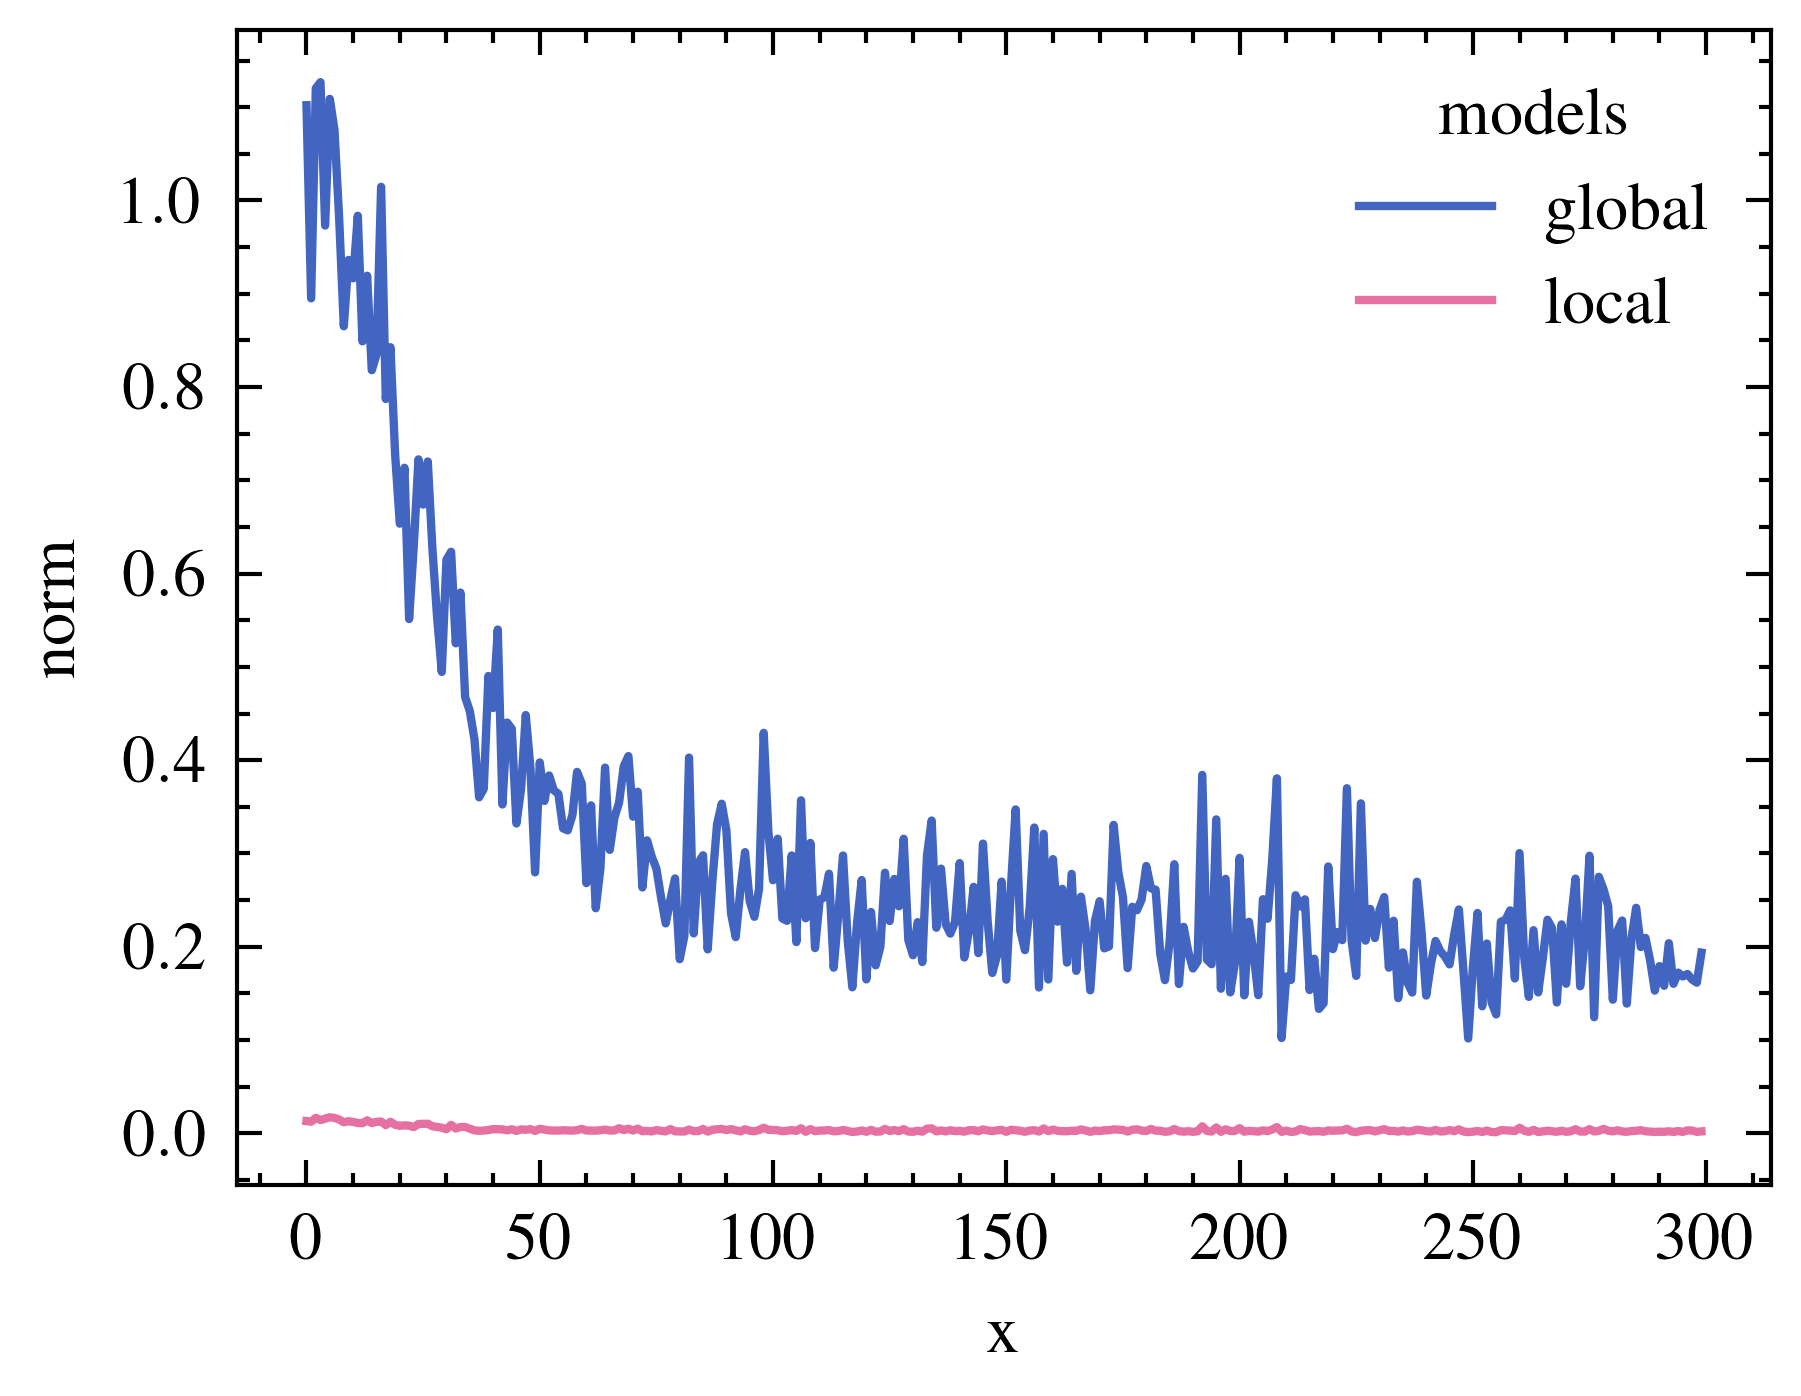

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
plt.style.use(['science','ieee','retro'])

sns.lineplot(data=df_norm_pplot,x='x',y='norm',hue="models")


plt.show()

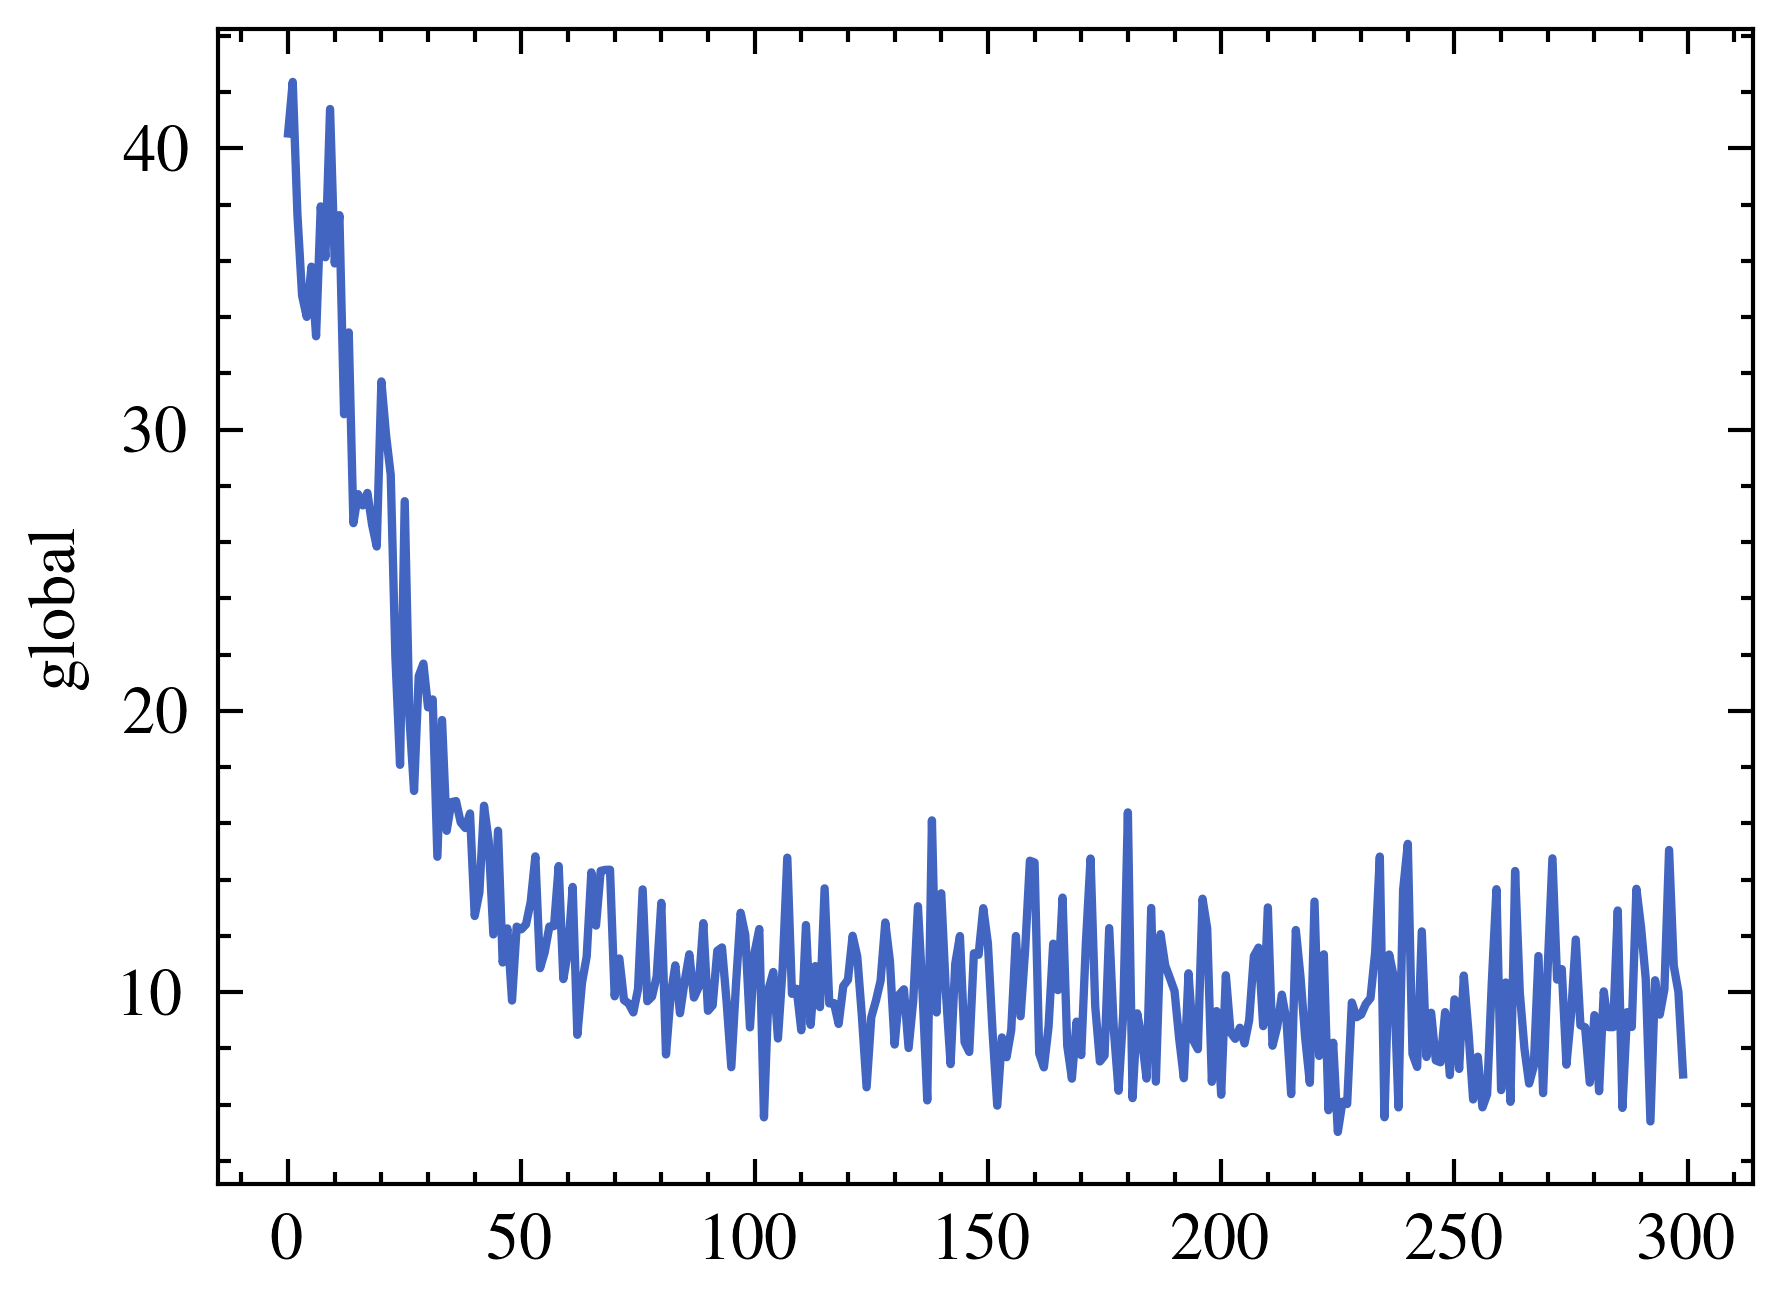

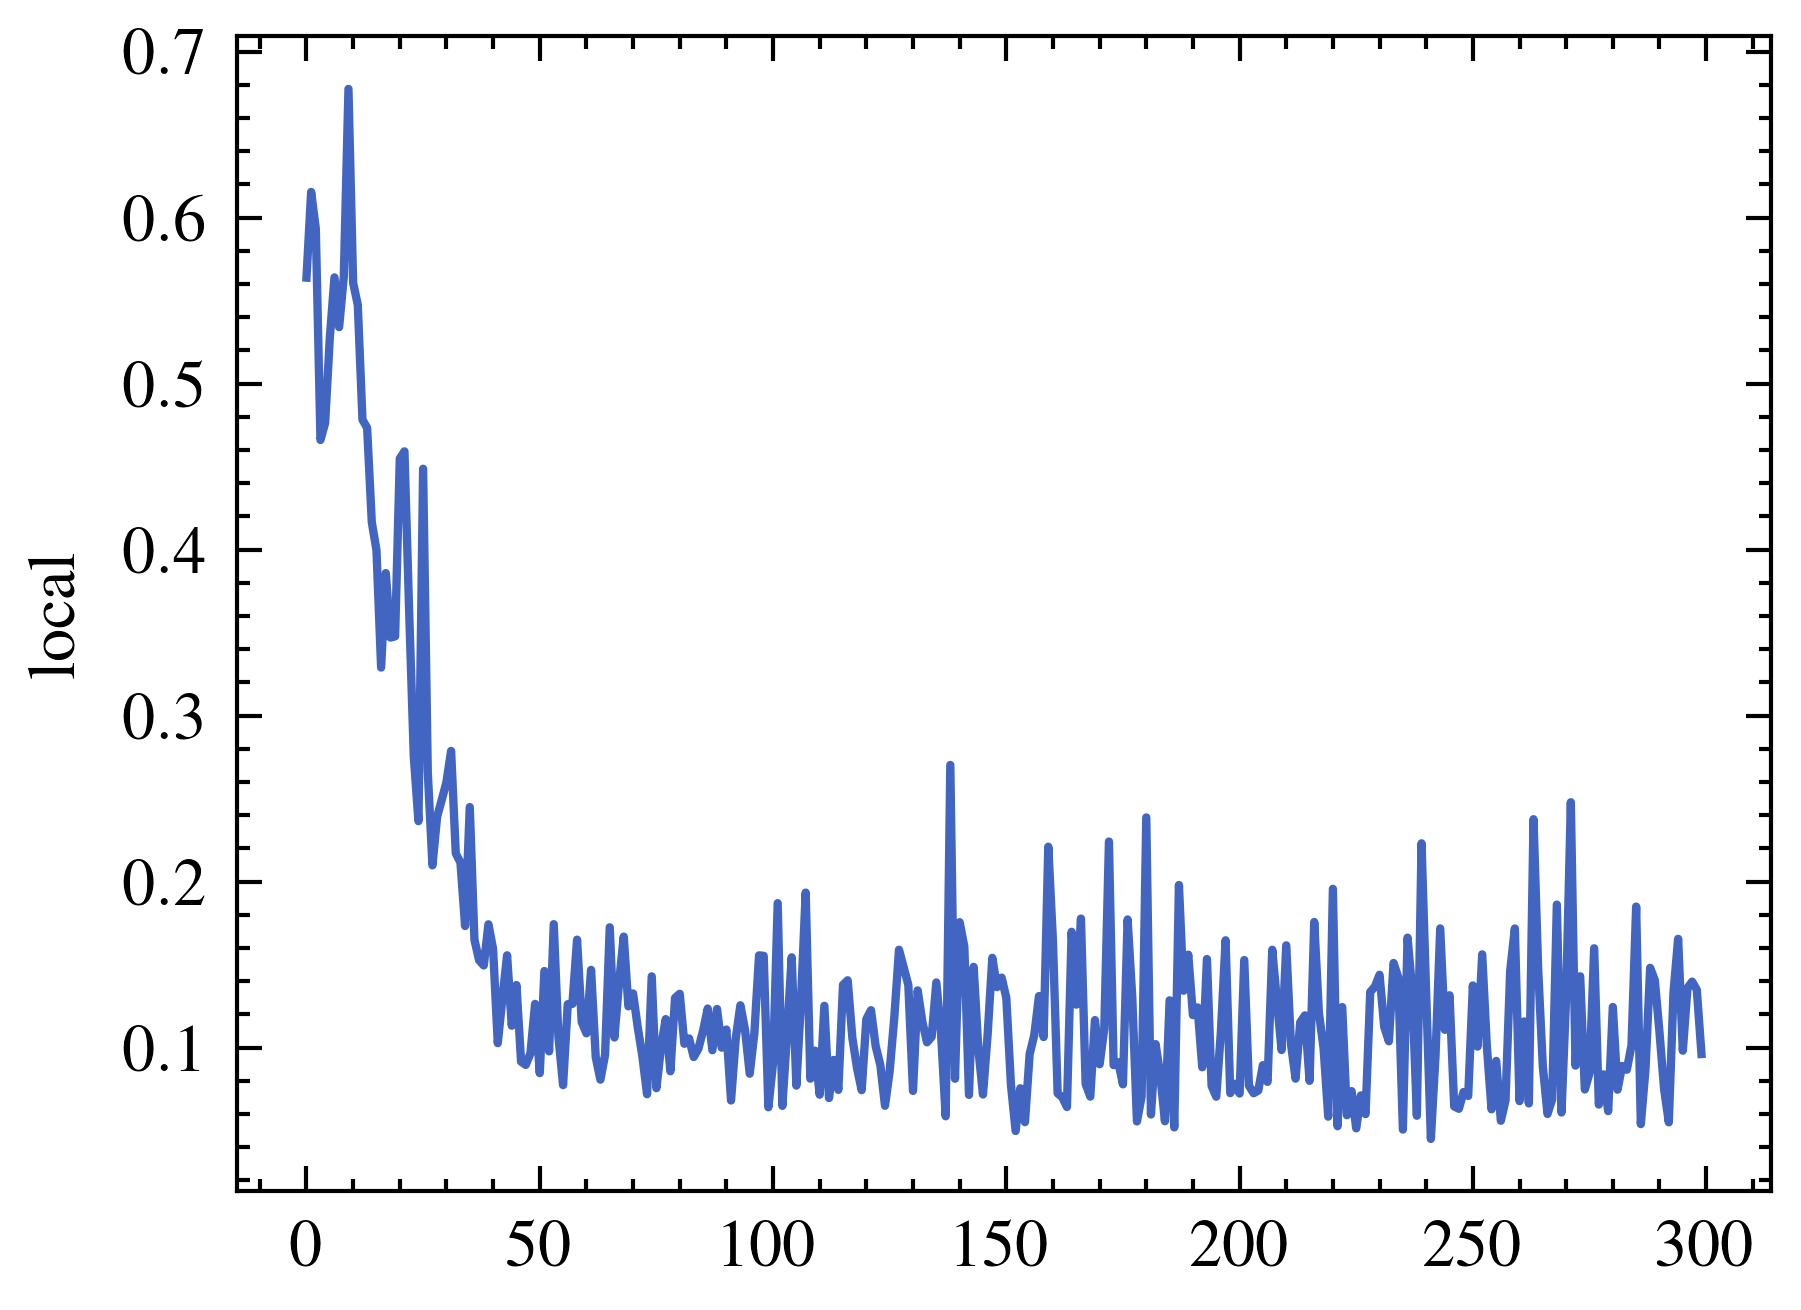

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
plt.style.use(['science','ieee','retro'])

sns.lineplot(data=df_norm_pplot,x=df_norm_pplot.index,y='global')
plt.show()
sns.lineplot(data=df_norm_pplot,x=df_norm_pplot.index,y='local')
plt.show()